In [3]:
import pandas as pd
import glob

# Be careful for changes at final github
working_pattern = 'DivvyData_part*.csv'

chunk_files = sorted(glob.glob(working_pattern))
data_chunks = []
for file in chunk_files:
    chunk = pd.read_csv(file, low_memory=False)
    data_chunks.append(chunk)
data = pd.concat(data_chunks, ignore_index=True)
del data_chunks

In [ ]:
### Final Cleaning for logistic regression
df = data[data['trip_duration_minutes']<=240]
df = df.drop(['ride_id', 'start_station_name','start_station_id','end_station_name', 'end_station_id', 'started_at_CT', 'day_of_week', 'end_hour', 'trip_duration_minutes', 'end_lat', 'end_lng'], axis=1)
df = df[df['rideable_type'] != 'electric_scooter']

# Make Months categorical from data stamp and then make by season
df['date'] = pd.to_datetime(df['date'])
df['month_num'] = df['date'].dt.month
df['month_name'] = df['date'].dt.strftime('%B')  
df = df.drop(['date', 'month_num' ], axis=1)
df['season'] = df['month_name'].map({
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
})

# Group hours 
def categorize_hour(hour):
    if 6 <= hour <= 9:
        return '6-9AM: Early Morning'
    elif 10 <= hour <= 15:
        return '10AM-3PM: Midday'
    elif 16 <= hour <= 19:
        return '4-7PM: Early Evening'
    elif 20 <= hour <= 23:
        return '8-11PM: Evening'
    else:  # 0-5
        return '12-5AM: Overnight'

df['hour'] = df['hour'].apply(categorize_hour)

df = df.drop(['month_name', 'ended_at_CT'], axis = 1)



Class distribution:
trip_category
commuter             2897771
extended_commuter     786965
recreational          192906
Name: count, dtype: int64
Class distribution percentages:
trip_category
commuter             74.730236
extended_commuter    20.294937
recreational          4.974827
Name: count, dtype: float64


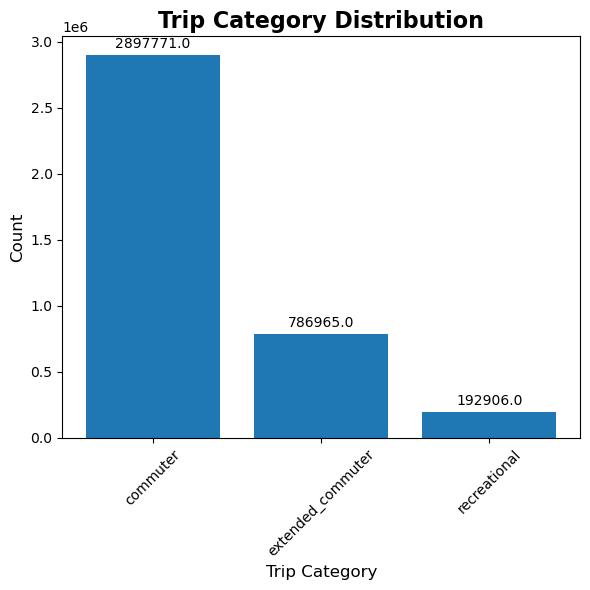

In [5]:
# Check class distribution
from matplotlib import pyplot as plt


class_distribution = df['trip_category'].value_counts()
print("Class distribution:")
print(class_distribution)
print(f"Class distribution percentages:")
print(class_distribution / len(df['trip_category']) * 100)

plt.figure(figsize=(6, 6))
bars = plt.bar(class_distribution.index, class_distribution.values)
plt.title('Trip Category Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Trip Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [6]:
## Using LAbel Encoding for target
category_mapping = {
    'commuter': 0,
    'extended_commuter': 1,
    'recreational': 2
}
target = df['trip_category'].map(category_mapping)

## Performing Logistic Regression

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X = df.drop(['trip_category'], axis = 1)
y = target
categorical_features = ['hour', 'season', 'member_casual', 'rideable_type', 'is_weekend']
numerical_features = ['start_lat', 'start_lng']

# Create a stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.5, 
    random_state=42, 
    stratify=y
)

# Process columns
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights 
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_counts = np.bincount(y_train)

classes = np.unique(y_train)
class_counts = np.bincount(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
weights_dict = {i: weight for i, weight in zip(classes, class_weights)}

print("Class weights:")
print(weights_dict)
print("\n" + "="*50)
print("MODEL COMPARISON USING WEIGHTED F1")
print("="*50)

# MULTINOMIAL LOGISTIC REGRESSION
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight=weights_dict,
    C=1.0
)

# Train and predict
log_reg.fit(X_train_processed, y_train)
y_pred_log = log_reg.predict(X_test_processed)

# Calculate weighted F1
weighted_f1_log = f1_score(y_test, y_pred_log, average='weighted')

print("\nMultinomial Logistic Regression:")
print(f"Weighted F1 Score: {weighted_f1_log:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(
    y_test, y_pred_log,
    target_names=['commuter', 'extended_commuter', 'recreational']
))

Class weights:
{0: 0.44604897329095594, 1: 1.6424436803284175, 2: 6.700399849322122}

MODEL COMPARISON USING WEIGHTED F1

Multinomial Logistic Regression:
Weighted F1 Score: 0.5741

Detailed Classification Report:
                   precision    recall  f1-score   support

         commuter       0.84      0.59      0.69   1448886
extended_commuter       0.23      0.21      0.22    393482
     recreational       0.13      0.77      0.22     96453

         accuracy                           0.52   1938821
        macro avg       0.40      0.52      0.38   1938821
     weighted avg       0.68      0.52      0.57   1938821



### Support Vectors

In [9]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC

# 2. CRAMMER & SINGER SVM
svm = LinearSVC(
    dual='auto',
    multi_class='crammer_singer',
    class_weight=weights_dict,
    C=0.5,
    max_iter=2000
)

# Train and predict
svm.fit(X_train_processed, y_train)
y_pred_svm = svm.predict(X_test_processed)

# Calculate weighted F1
weighted_f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("\nCrammer & Singer SVM:")
print(f"Weighted F1 Score: {weighted_f1_svm:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(
    y_test, y_pred_svm,
    target_names=['commuter', 'extended_commuter', 'recreational']
))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Crammer & Singer SVM:
Weighted F1 Score: 0.6011

Detailed Classification Report:
                   precision    recall  f1-score   support

         commuter       0.82      0.76      0.79   1448886
extended_commuter       0.33      0.00      0.00    393482
     recreational       0.13      0.78      0.22     96453

         accuracy                           0.61   1938821
        macro avg       0.43      0.51      0.34   1938821
     weighted avg       0.69      0.61      0.60   1938821



### Hyperparameter tuning (C) for SVM (Better model)

Using 100000 samples for hyperparameter tuning...
Performing hyperparameter tuning using weighted F1...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the n


Results for each C value:
C = 0.010000: Weighted F1 = 0.6020 ± 0.0010
C = 0.027826: Weighted F1 = 0.6026 ± 0.0010
C = 0.077426: Weighted F1 = 0.6028 ± 0.0011
C = 0.215443: Weighted F1 = 0.6029 ± 0.0011
C = 0.599484: Weighted F1 = 0.6032 ± 0.0012
C = 1.668101: Weighted F1 = 0.6051 ± 0.0029
C = 4.641589: Weighted F1 = 0.6048 ± 0.0040
C = 12.915497: Weighted F1 = 0.6027 ± 0.0010
C = 35.938137: Weighted F1 = 0.6038 ± 0.0039
C = 100.000000: Weighted F1 = 0.3775 ± 0.1265

Best C value: 1.6681005372000592
Best cross-validation weighted F1 score: 0.6051


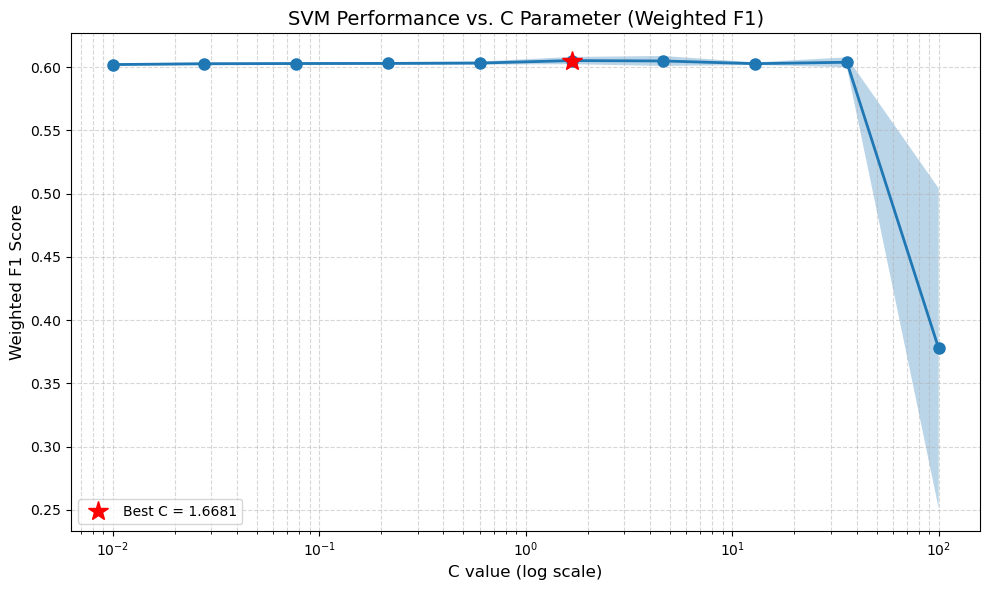


Training final model with C = 1.6681005372000592 on full dataset...
Full dataset size: 1938821 samples
[LibLinear].............................................*..............................................................................................................*.................................................................................................................*.................................*....................................................*......................................................................*..........................................................*....................................................................................*...............................................................................................................................*........................................................................................................................................................................................

/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Test set weighted F1: 0.6011

Best Linear SVM Classification Report:
                   precision    recall  f1-score   support

         commuter       0.82      0.76      0.79   1448886
extended_commuter       0.29      0.00      0.00    393482
     recreational       0.13      0.78      0.22     96453

         accuracy                           0.61   1938821
        macro avg       0.41      0.51      0.34   1938821
     weighted avg       0.68      0.61      0.60   1938821



In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer, balanced_accuracy_score

param_grid = {
    'C': np.logspace(-2, 2, 10) 
}
c_values = np.logspace(-2, 2, 10)

# Create LinearSVC 
svm = LinearSVC(
    dual='auto',
    multi_class='crammer_singer',
    class_weight=weights_dict,
    max_iter=2000,
    random_state=42,
    tol=0.001 
)

weighted_f1_scorer = make_scorer(f1_score, average='weighted')

#Sample for optimization
sample_size = min(100000, len(X_train_processed))  
indices = np.random.choice(len(X_train_processed), sample_size, replace=False)
X_sample = X_train_processed[indices]
y_sample = y_train.iloc[indices] if hasattr(y_train, 'iloc') else y_train[indices]

print(f"Using {sample_size} samples for hyperparameter tuning...")

# Create grid search cv
grid_search = GridSearchCV(
    svm,
    param_grid,
    scoring=weighted_f1_scorer,
    cv=3,  
    n_jobs=-1,
    verbose=1
)

# Fit grid search
print("Performing hyperparameter tuning using weighted F1...")
grid_search.fit(X_sample, y_sample)


# Print results for C values
print("\nResults for each C value:")
for i, c in enumerate(c_values):
    mean_score = grid_search.cv_results_['mean_test_score'][i]
    std_score = grid_search.cv_results_['std_test_score'][i]
    print(f"C = {c:.6f}: Weighted F1 = {mean_score:.4f} ± {std_score:.4f}")

# Print best parameters
print(f"\nBest C value: {grid_search.best_params_['C']}")
print(f"Best cross-validation weighted F1 score: {grid_search.best_score_:.4f}")

# Quick visualization
plt.figure(figsize=(10, 6))
plt.semilogx(c_values, grid_search.cv_results_['mean_test_score'], 'o-', linewidth=2, markersize=8)
plt.fill_between(
    c_values,
    grid_search.cv_results_['mean_test_score'] - grid_search.cv_results_['std_test_score'],
    grid_search.cv_results_['mean_test_score'] + grid_search.cv_results_['std_test_score'],
    alpha=0.3
)
plt.xlabel('C value (log scale)', fontsize=12)
plt.ylabel('Weighted F1 Score', fontsize=12)
plt.title('SVM Performance vs. C Parameter (Weighted F1)', fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.5)
best_idx = np.argmax(grid_search.cv_results_['mean_test_score'])
plt.plot(c_values[best_idx], grid_search.cv_results_['mean_test_score'][best_idx], 
         'r*', markersize=15, label=f'Best C = {grid_search.best_params_["C"]:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

# Train final model with best parameters on full dataset
best_C = grid_search.best_params_['C']
print(f"\nTraining final model with C = {best_C} on full dataset...")
print(f"Full dataset size: {len(X_train_processed)} samples")

best_svm = LinearSVC(
    dual='auto',
    multi_class='crammer_singer',
    class_weight=weights_dict,
    C=best_C,
    max_iter=2000,
    random_state=42,
    tol=0.001,  
    verbose=1   
)

best_svm.fit(X_train_processed, y_train)

# Evaluate on test set
y_pred_best = best_svm.predict(X_test_processed)
test_weighted_f1 = f1_score(y_test, y_pred_best, average='weighted')
print(f"\nTest set weighted F1: {test_weighted_f1:.4f}")

print("\nBest Linear SVM Classification Report:")
print(classification_report(
    y_test, y_pred_best,
    target_names=['commuter', 'extended_commuter', 'recreational']
))

## Not much difference in c values. Continue trying to hypertune with threshold

/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Iteration 0/81: Extended=-2.00, Recreational=-2.00, Weighted F1=0.6392
Iteration 10/81: Extended=-1.50, Recreational=-1.50, Weighted F1=0.6392
Iteration 20/81: Extended=-1.00, Recreational=-1.00, Weighted F1=0.6477
Iteration 30/81: Extended=-0.50, Recreational=-0.50, Weighted F1=0.6221
Iteration 40/81: Extended=0.00, Recreational=0.00, Weighted F1=0.6012
Iteration 50/81: Extended=0.50, Recreational=0.50, Weighted F1=0.3990
Iteration 60/81: Extended=1.00, Recreational=1.00, Weighted F1=0.0902
Iteration 70/81: Extended=1.50, Recreational=1.50, Weighted F1=0.0515
Iteration 80/81: Extended=2.00, Recreational=2.00, Weighted F1=0.0515

Best thresholds based on WEIGHTED F1:
Extended_commuter threshold: 0.0000
Recreational threshold: -1.0000
Resulting weighted F1: 0.6902
Resulting balanced accuracy: 0.4151
Resulting standard accuracy: 0.7099

Classification Report with Optimized Thresholds (Weighted F1):
                   precision    recall  f1-score   support

         commuter       0.80  

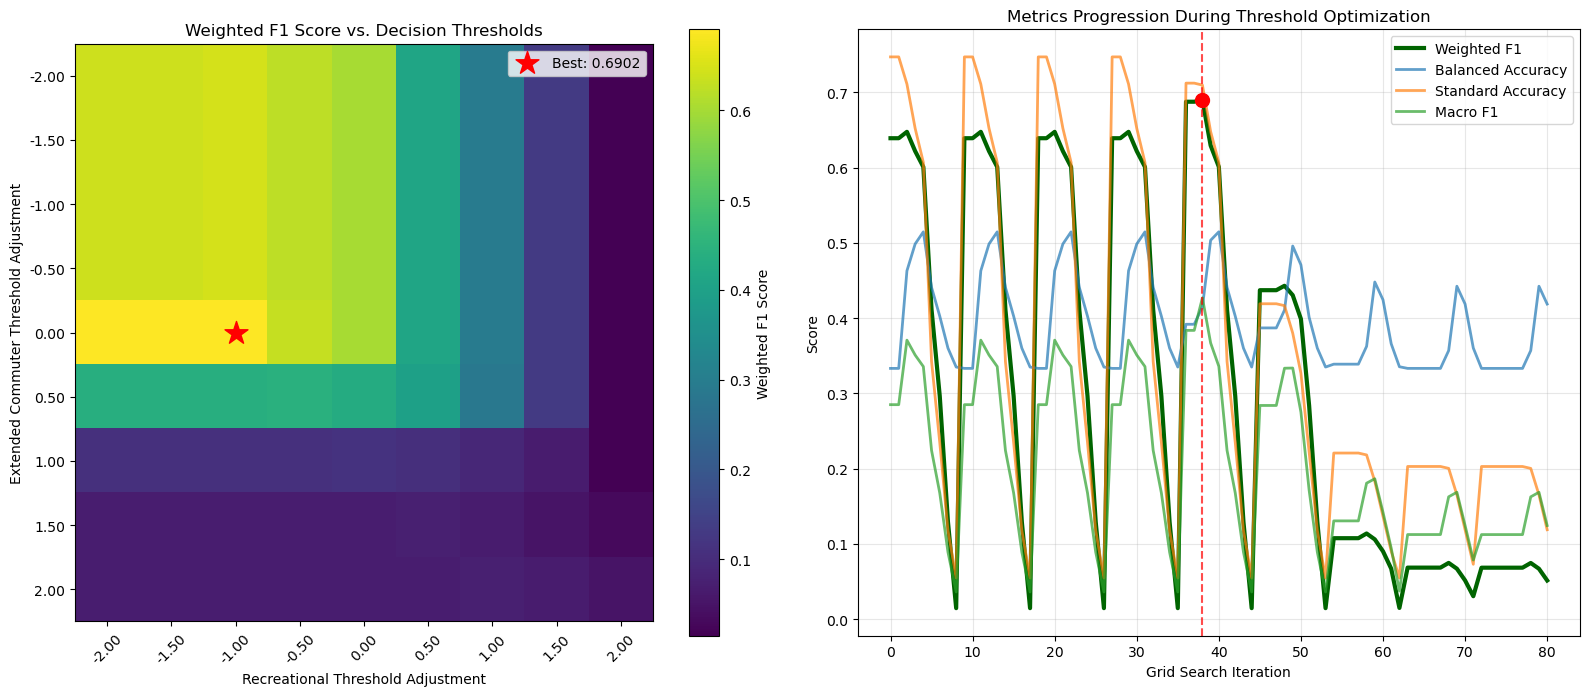

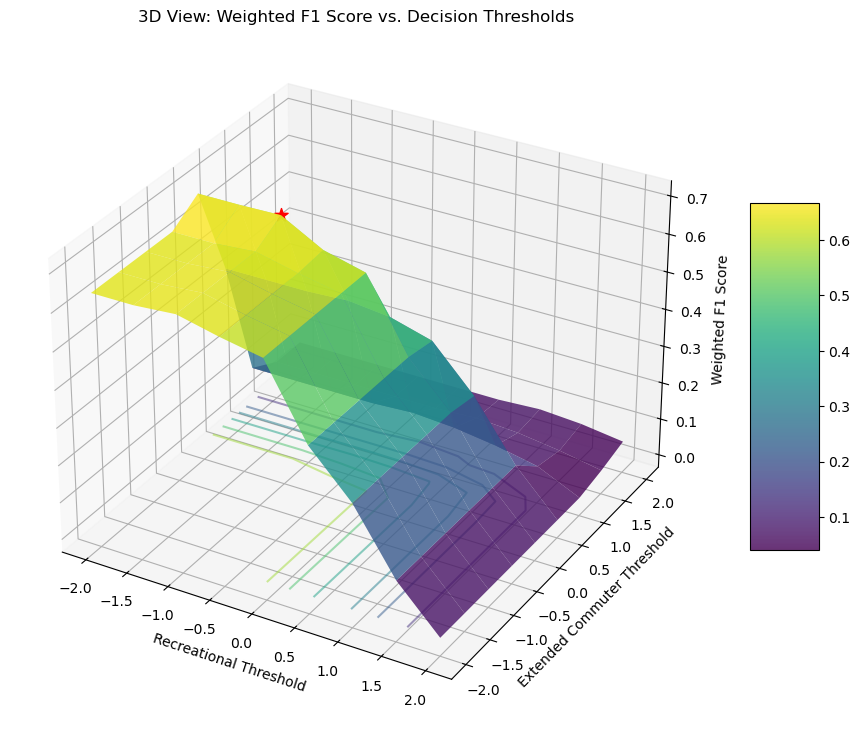


THRESHOLD OPTIMIZATION SUMMARY
Optimization Metric: Weighted F1
Best Extended Commuter Threshold: 0.0000
Best Recreational Threshold: -1.0000
Achieved Weighted F1: 0.6902
Corresponding Balanced Accuracy: 0.4151
Corresponding Standard Accuracy: 0.7099


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# train SVM model with the best C value
best_svm = LinearSVC(
    dual='auto',
    multi_class='crammer_singer',  
    class_weight=weights_dict,
    C=best_C,  # Use your best C value here
    max_iter=2000,
    random_state=42
)

# Fit on the training data
best_svm.fit(X_train_processed, y_train)
decision_scores = best_svm.decision_function(X_test_processed)

# Adjust thresholds for the minority classes
thresholds_extended = np.linspace(-2, 2, 9)  
thresholds_recreational = np.linspace(-2, 2, 9)  

threshold_grid = np.array(np.meshgrid(thresholds_extended, thresholds_recreational)).T.reshape(-1, 2)

# Perform grid search
results = []
for i, (t_extended, t_recreational) in enumerate(threshold_grid):
    adjusted_scores = decision_scores.copy()
    adjusted_scores[:, 1] += t_extended  
    adjusted_scores[:, 2] += t_recreational 
    
    # Get predictions 
    y_pred = np.argmax(adjusted_scores, axis=1)
    
    # Calculate metrics
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    std_acc = (y_pred == y_test).mean()
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    
    results.append((t_extended, t_recreational, weighted_f1, bal_acc, std_acc, macro_f1))
    
    # Print progress every 10 iterations
    if i % 10 == 0:
        print(f"Iteration {i}/{len(threshold_grid)}: Extended={t_extended:.2f}, Recreational={t_recreational:.2f}, "
              f"Weighted F1={weighted_f1:.4f}")

results_df = pd.DataFrame(results, columns=['Threshold_Extended', 'Threshold_Recreational', 
                                           'Weighted_F1', 'Balanced_Accuracy', 'Accuracy', 'Macro_F1'])

# Find best thresholds
best_idx = results_df['Weighted_F1'].idxmax()
best_thresholds = results_df.iloc[best_idx]

print("\nBest thresholds based on WEIGHTED F1:")
print(f"Extended_commuter threshold: {best_thresholds['Threshold_Extended']:.4f}")
print(f"Recreational threshold: {best_thresholds['Threshold_Recreational']:.4f}")
print(f"Resulting weighted F1: {best_thresholds['Weighted_F1']:.4f}")
print(f"Resulting balanced accuracy: {best_thresholds['Balanced_Accuracy']:.4f}")
print(f"Resulting standard accuracy: {best_thresholds['Accuracy']:.4f}")
 
best_t_extended = best_thresholds['Threshold_Extended']
best_t_recreational = best_thresholds['Threshold_Recreational']

adjusted_scores_best = decision_scores.copy()
adjusted_scores_best[:, 1] += best_t_extended
adjusted_scores_best[:, 2] += best_t_recreational

y_pred_best = np.argmax(adjusted_scores_best, axis=1)

print("\nClassification Report with Optimized Thresholds (Weighted F1):")
print(classification_report(
    y_test, y_pred_best,
    target_names=['commuter', 'extended_commuter', 'recreational']
))

# Calculate final weighted F1
final_weighted_f1 = f1_score(y_test, y_pred_best, average='weighted')
print(f"\nFinal Weighted F1 Score: {final_weighted_f1:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

pivot_f1 = results_df.pivot_table(
    index='Threshold_Extended', 
    columns='Threshold_Recreational',
    values='Weighted_F1'
)

im1 = ax1.imshow(pivot_f1, interpolation='nearest', cmap='viridis')
ax1.set_xticks(range(len(pivot_f1.columns)))
ax1.set_xticklabels([f"{x:.2f}" for x in pivot_f1.columns], rotation=45)
ax1.set_yticks(range(len(pivot_f1.index)))
ax1.set_yticklabels([f"{x:.2f}" for x in pivot_f1.index])
ax1.set_xlabel('Recreational Threshold Adjustment')
ax1.set_ylabel('Extended Commuter Threshold Adjustment')
ax1.set_title('Weighted F1 Score vs. Decision Thresholds')
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Weighted F1 Score')

best_extended_idx = list(pivot_f1.index).index(best_thresholds['Threshold_Extended'])
best_recreational_idx = list(pivot_f1.columns).index(best_thresholds['Threshold_Recreational'])
ax1.scatter(best_recreational_idx, best_extended_idx, color='red', marker='*', s=300, 
           label=f'Best: {best_thresholds["Weighted_F1"]:.4f}')
ax1.legend()

# Line plot of metric progression
ax2.plot(range(len(results_df)), results_df['Weighted_F1'], label='Weighted F1', linewidth=3, color='darkgreen')
ax2.plot(range(len(results_df)), results_df['Balanced_Accuracy'], label='Balanced Accuracy', linewidth=2, alpha=0.7)
ax2.plot(range(len(results_df)), results_df['Accuracy'], label='Standard Accuracy', linewidth=2, alpha=0.7)
ax2.plot(range(len(results_df)), results_df['Macro_F1'], label='Macro F1', linewidth=2, alpha=0.7)
ax2.set_xlabel('Grid Search Iteration')
ax2.set_ylabel('Score')
ax2.set_title('Metrics Progression During Threshold Optimization')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax2.axvline(x=best_idx, color='red', linestyle='--', alpha=0.7, label='Best Weighted F1')
ax2.scatter(best_idx, best_thresholds['Weighted_F1'], color='red', s=100, zorder=5)

plt.tight_layout()
plt.show()



# Summary of results
print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION SUMMARY")
print("="*60)
print(f"Optimization Metric: Weighted F1")
print(f"Best Extended Commuter Threshold: {best_thresholds['Threshold_Extended']:.4f}")
print(f"Best Recreational Threshold: {best_thresholds['Threshold_Recreational']:.4f}")
print(f"Achieved Weighted F1: {best_thresholds['Weighted_F1']:.4f}")
print(f"Corresponding Balanced Accuracy: {best_thresholds['Balanced_Accuracy']:.4f}")
print(f"Corresponding Standard Accuracy: {best_thresholds['Accuracy']:.4f}")
print("="*60)



## Feature Importance


Top 15 features for 'commuter' class:
                        Feature  Coefficient  Abs_Coefficient
12         member_casual_member     0.233165         0.233165
14  rideable_type_electric_bike     0.179206         0.179206
10                season_Winter     0.169195         0.169195
11         member_casual_casual    -0.161609         0.161609
6          hour_8-11PM: Evening     0.127345         0.127345
15                 is_weekend_0     0.121888         0.121888
13   rideable_type_classic_bike    -0.107650         0.107650
5     hour_6-9AM: Early Morning    -0.097640         0.097640
9                 season_Summer    -0.084935         0.084935
1                     start_lng    -0.071210         0.071210
0                     start_lat    -0.070891         0.070891
3        hour_12-5AM: Overnight     0.065188         0.065188
2         hour_10AM-3PM: Midday    -0.062344         0.062344
16                 is_weekend_1    -0.050332         0.050332
8                 season_Spring

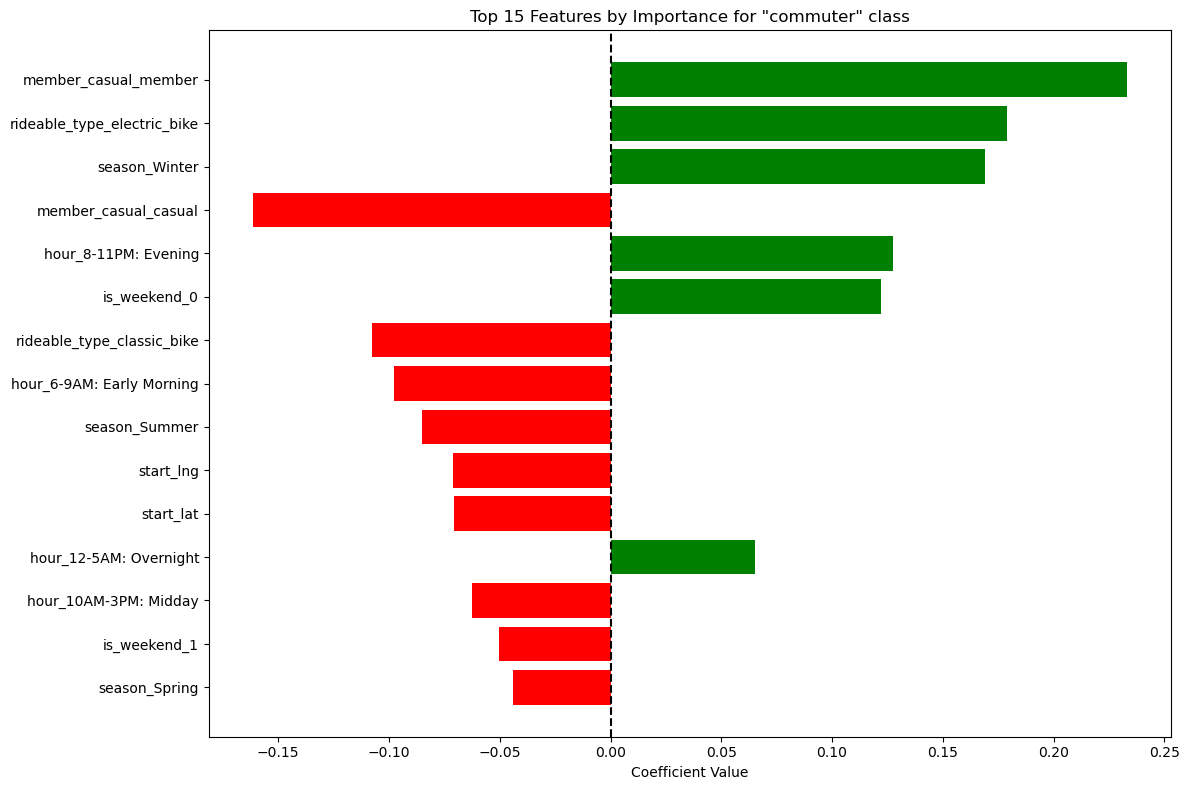


Top 15 features for 'extended_commuter' class:
                        Feature  Coefficient  Abs_Coefficient
14  rideable_type_electric_bike    -0.180044         0.180044
12         member_casual_member    -0.170240         0.170240
10                season_Winter    -0.149856         0.149856
15                 is_weekend_0    -0.140973         0.140973
6          hour_8-11PM: Evening    -0.113239         0.113239
3        hour_12-5AM: Overnight    -0.086514         0.086514
0                     start_lat     0.056781         0.056781
7                   season_Fall    -0.047537         0.047537
2         hour_10AM-3PM: Midday     0.041090         0.041090
9                 season_Summer     0.038669         0.038669
1                     start_lng     0.035474         0.035474
5     hour_6-9AM: Early Morning     0.029259         0.029259
4     hour_4-7PM: Early Evening    -0.026049         0.026049
13   rideable_type_classic_bike     0.024592         0.024592
11         member_casu

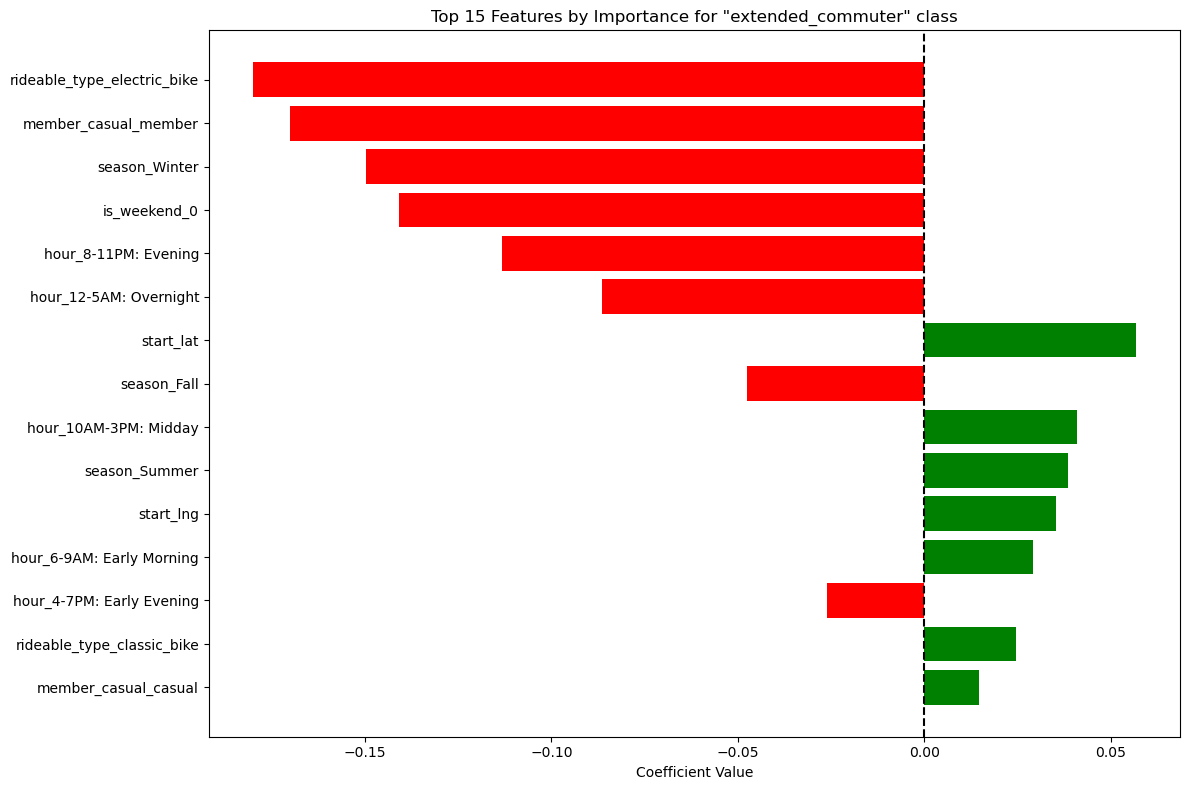


Top 15 features for 'recreational' class:
                        Feature  Coefficient  Abs_Coefficient
12         member_casual_member    -0.432556         0.432556
11         member_casual_casual     0.232649         0.232649
14  rideable_type_electric_bike    -0.227151         0.227151
15                 is_weekend_0    -0.175383         0.175383
10                season_Winter    -0.170514         0.170514
4     hour_4-7PM: Early Evening    -0.146206         0.146206
1                     start_lng     0.140959         0.140959
6          hour_8-11PM: Evening    -0.134161         0.134161
5     hour_6-9AM: Early Morning     0.120458         0.120458
7                   season_Fall    -0.069628         0.069628
0                     start_lat     0.056317         0.056317
9                 season_Summer     0.028745         0.028745
13   rideable_type_classic_bike     0.027244         0.027244
16                 is_weekend_1    -0.024524         0.024524
2         hour_10AM-3PM: Mi

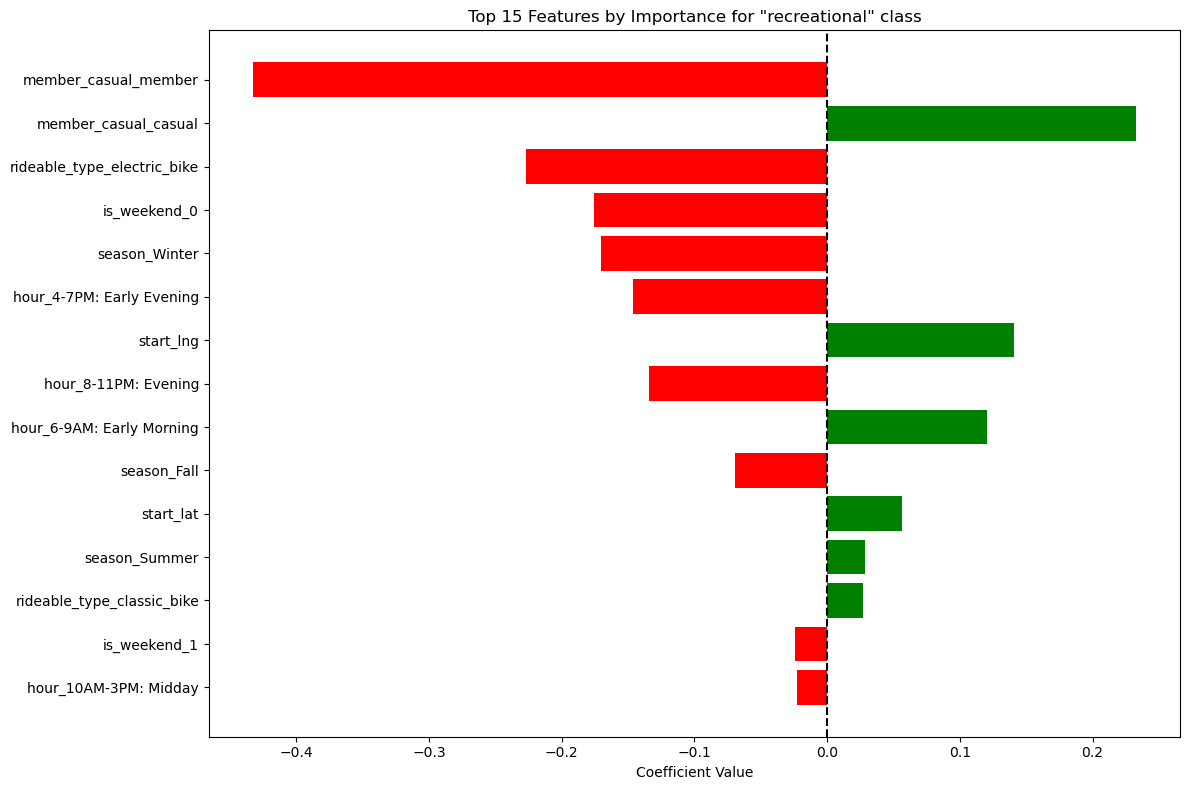


Top 20 most important features (averaged across all classes):
                        Feature  Average_Importance
12         member_casual_member            0.278654
14  rideable_type_electric_bike            0.195467
10                season_Winter            0.163189
15                 is_weekend_0            0.146081
11         member_casual_casual            0.136349
6          hour_8-11PM: Evening            0.124915
1                     start_lng            0.082548
5     hour_6-9AM: Early Morning            0.082452
4     hour_4-7PM: Early Evening            0.070421
0                     start_lat            0.061330
3        hour_12-5AM: Overnight            0.056373
13   rideable_type_classic_bike            0.053162
9                 season_Summer            0.050783
7                   season_Fall            0.049505
2         hour_10AM-3PM: Midday            0.042005
16                 is_weekend_1            0.029778
8                 season_Spring            0.019606


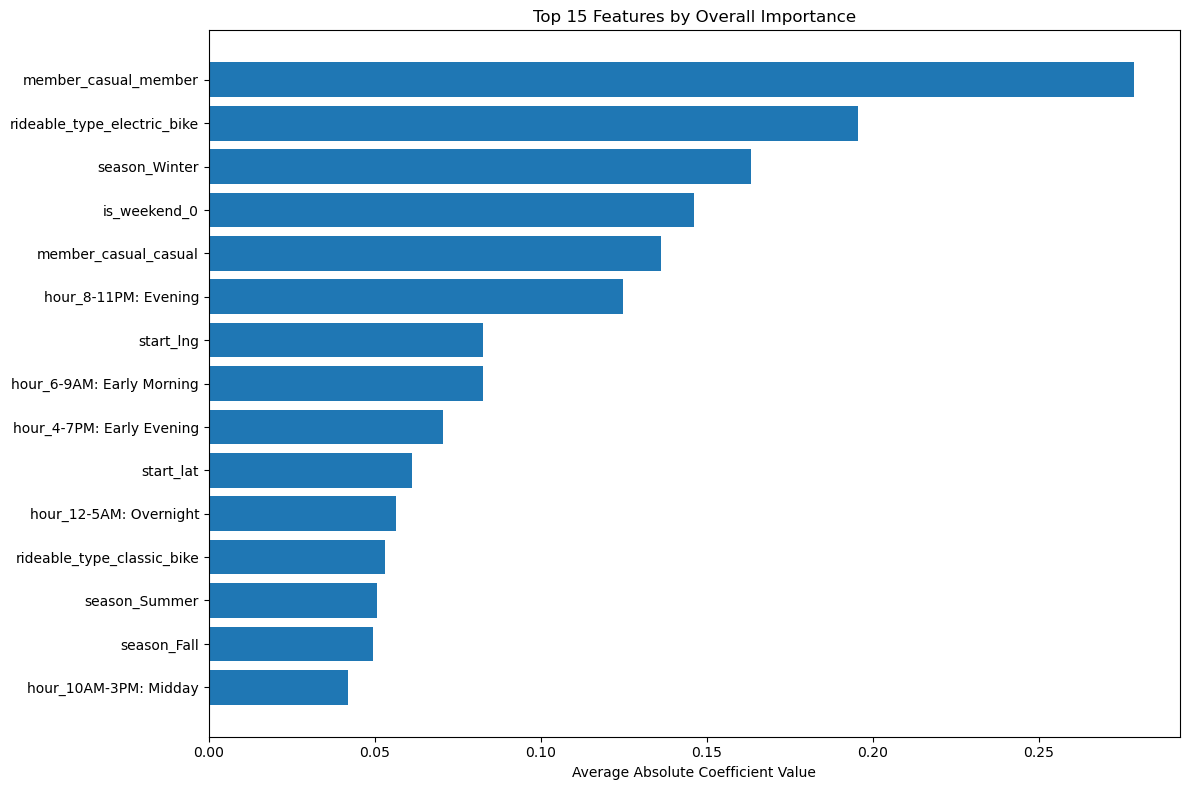


Feature importance by category:
    Category  Average_Importance
0     member            0.207501
1   rideable            0.124314
3         is            0.087930
4       hour            0.075233
5  Numerical            0.071939
2     season            0.070771


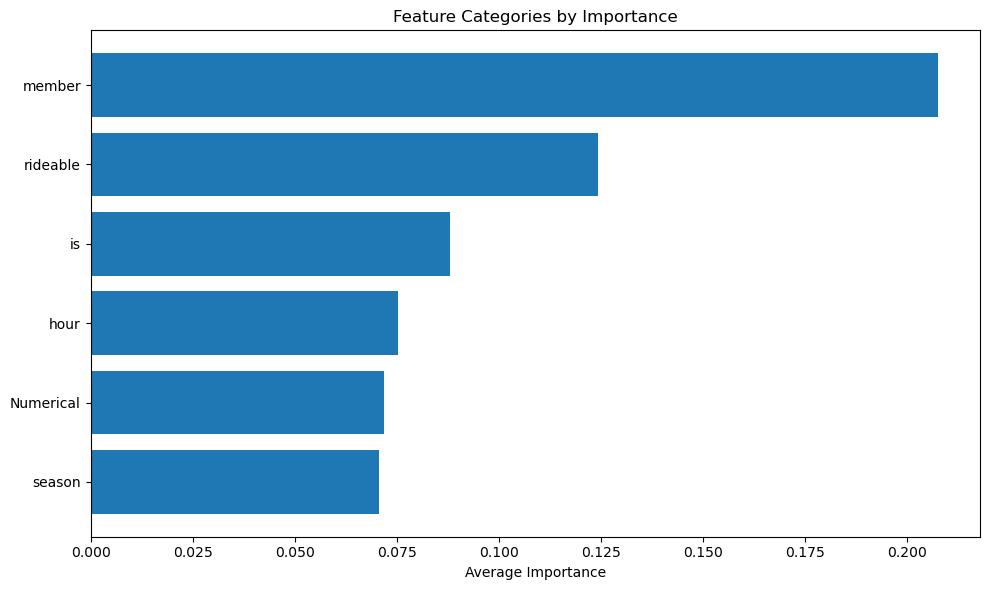

In [12]:
# Use best SVM model 
best_svm = LinearSVC(
    dual='auto',
    class_weight='balanced',
    C=best_C,  
    max_iter=2000,
    random_state=42
)

# Fit the model on full training data
best_svm.fit(X_train_processed, y_train)

# Get feature names
cat_encoder = preprocessor.named_transformers_['cat']
cat_features_encoded = cat_encoder.get_feature_names_out(categorical_features)
all_features = np.concatenate([numerical_features, cat_features_encoded])

# Get coefficients 
coefficients = best_svm.coef_
importance_dfs = []

for i, class_name in enumerate(['commuter', 'extended_commuter', 'recreational']):
    # Get coefficients for this class
    class_coeffs = coefficients[i]
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Coefficient': class_coeffs,
        'Abs_Coefficient': np.abs(class_coeffs)
    })
    
    importance_df = importance_df.sort_values('Abs_Coefficient', ascending=False)
    
    importance_dfs.append((class_name, importance_df))
    
    print(f"\nTop 15 features for '{class_name}' class:")
    print(importance_df.head(15))
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    colors = ['green' if x > 0 else 'red' for x in importance_df['Coefficient'][:15]]
    plt.barh(importance_df['Feature'][:15], importance_df['Coefficient'][:15], color=colors)
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 15 Features by Importance for "{class_name}" class')
    plt.axvline(x=0, color='black', linestyle='--')
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()

# Create overall feature importance by averaging absolute values across classes
avg_importance = {}

for feature in all_features:
    # Collect coefficients for this feature across all classes
    feature_coeffs = []
    for _, df in importance_dfs:
        coeff = df.loc[df['Feature'] == feature, 'Abs_Coefficient'].values[0]
        feature_coeffs.append(coeff)
    
    # Take the average
    avg_importance[feature] = np.mean(feature_coeffs)

# Create and sort DataFrame
overall_importance_df = pd.DataFrame({
    'Feature': list(avg_importance.keys()),
    'Average_Importance': list(avg_importance.values())
}).sort_values('Average_Importance', ascending=False)

# Display top 20 overall most important features
print("\nTop 20 most important features (averaged across all classes):")
print(overall_importance_df.head(20))

# Create visualization for overall importance
plt.figure(figsize=(12, 8))
plt.barh(overall_importance_df['Feature'][:15], overall_importance_df['Average_Importance'][:15])
plt.xlabel('Average Absolute Coefficient Value')
plt.title('Top 15 Features by Overall Importance')
plt.gca().invert_yaxis()  # To have highest importance at the top
plt.tight_layout()
plt.show()

# Group features by category to understand which types of features are most important
feature_categories = {}

# Assign categories to features
for feature in overall_importance_df['Feature']:
    if feature in numerical_features:
        category = 'Numerical'
    else:
        # Extract category from one-hot encoded feature name
        category = feature.split('_')[0]
    
    if category not in feature_categories:
        feature_categories[category] = []
    
    feature_categories[category].append(feature)

category_importance = {}

for category, features in feature_categories.items():
    importance_values = overall_importance_df[
        overall_importance_df['Feature'].isin(features)
    ]['Average_Importance'].values
    
    category_importance[category] = np.mean(importance_values)

category_df = pd.DataFrame({
    'Category': list(category_importance.keys()),
    'Average_Importance': list(category_importance.values())
}).sort_values('Average_Importance', ascending=False)

print("\nFeature importance by category:")
print(category_df)

plt.figure(figsize=(10, 6))
plt.barh(category_df['Category'], category_df['Average_Importance'])
plt.xlabel('Average Importance')
plt.title('Feature Categories by Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_79123/629844845.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=45, ha='right')
/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_79123/629844845.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=45, ha='right')
/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_79123/629844845.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=45, ha='right')


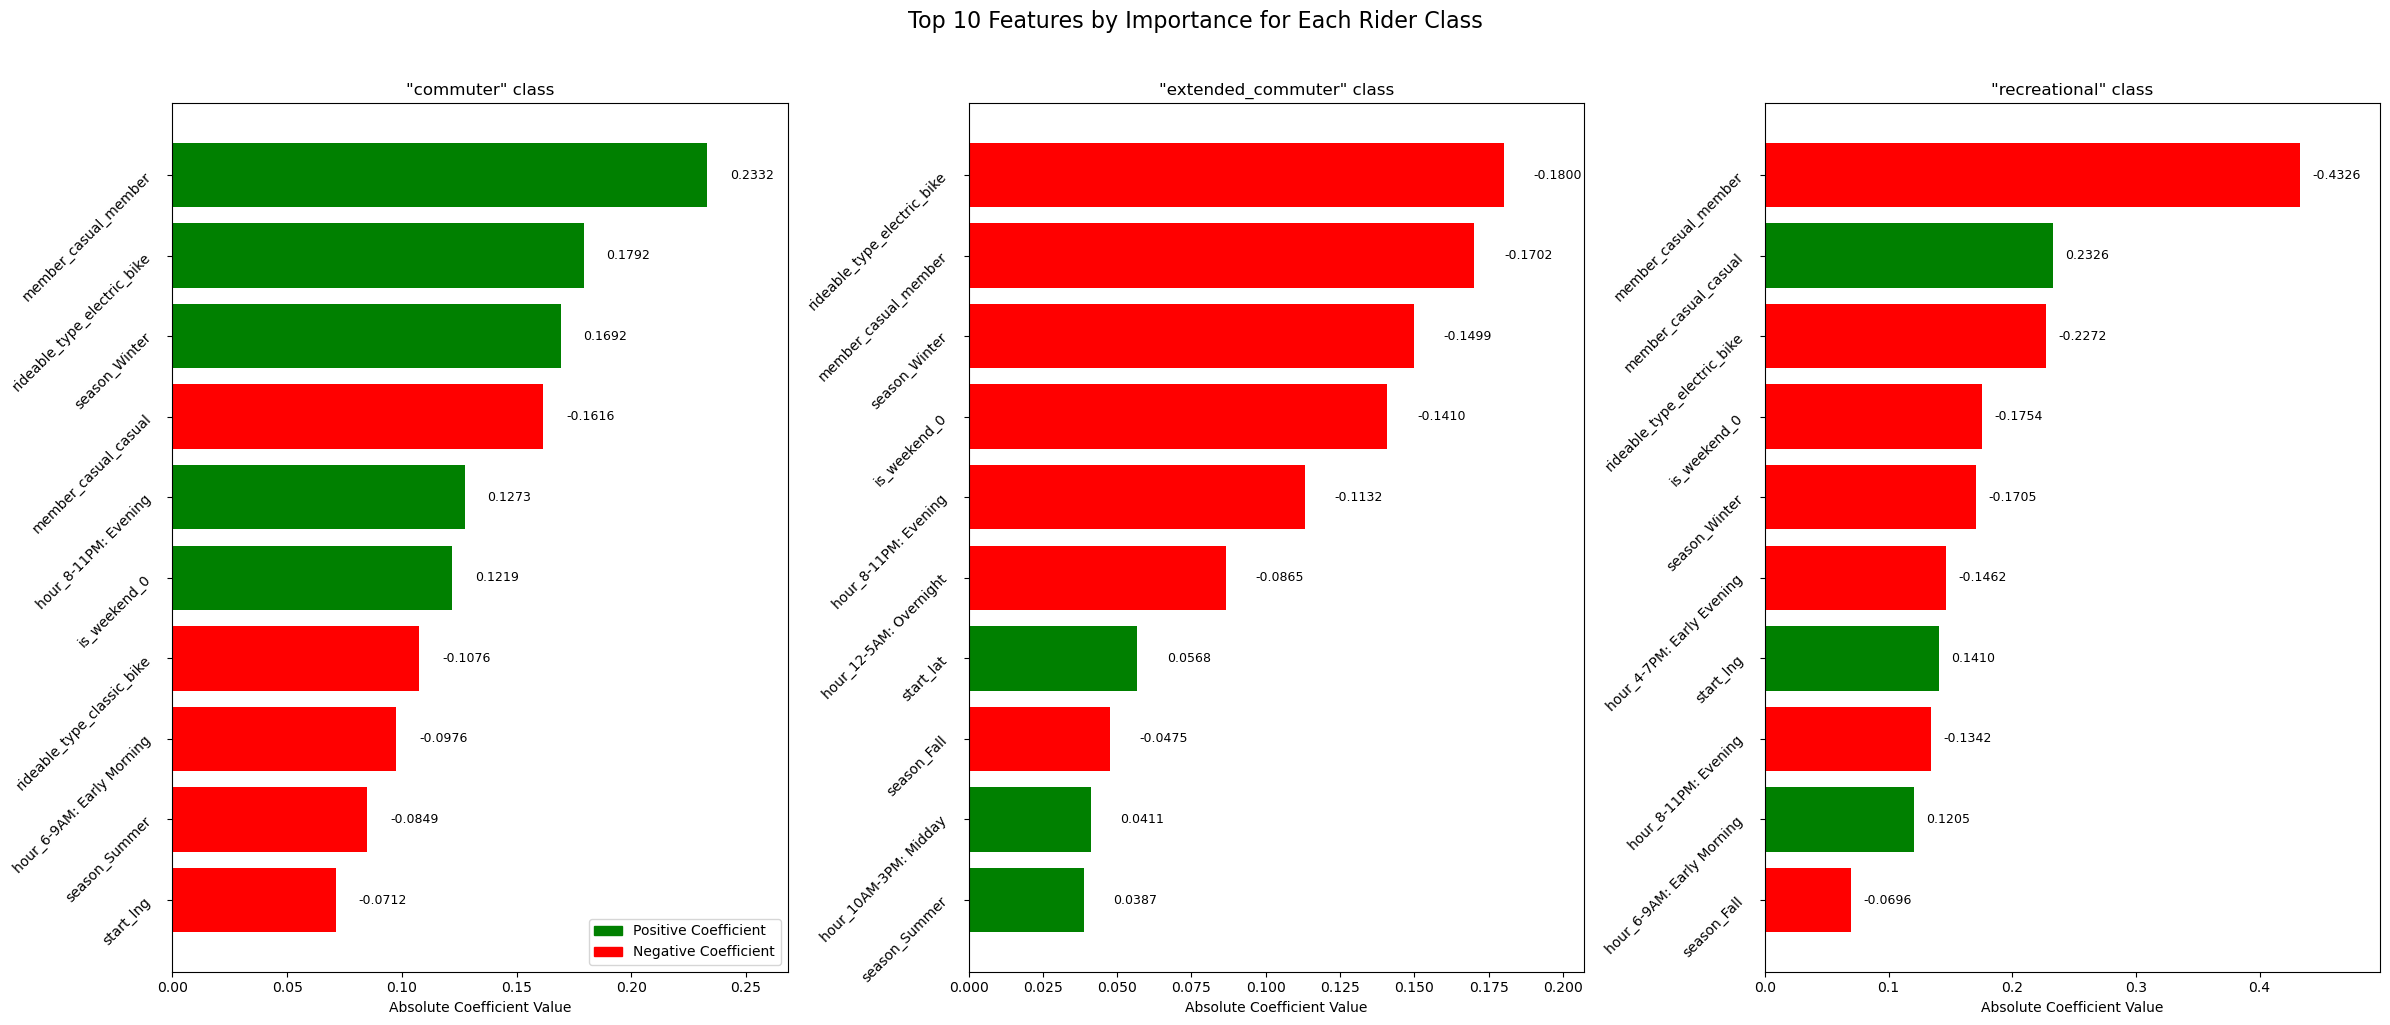

/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_79123/629844845.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), rotation=45, ha='right')
/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_79123/629844845.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(ax2.get_yticklabels(), rotation=45, ha='right')


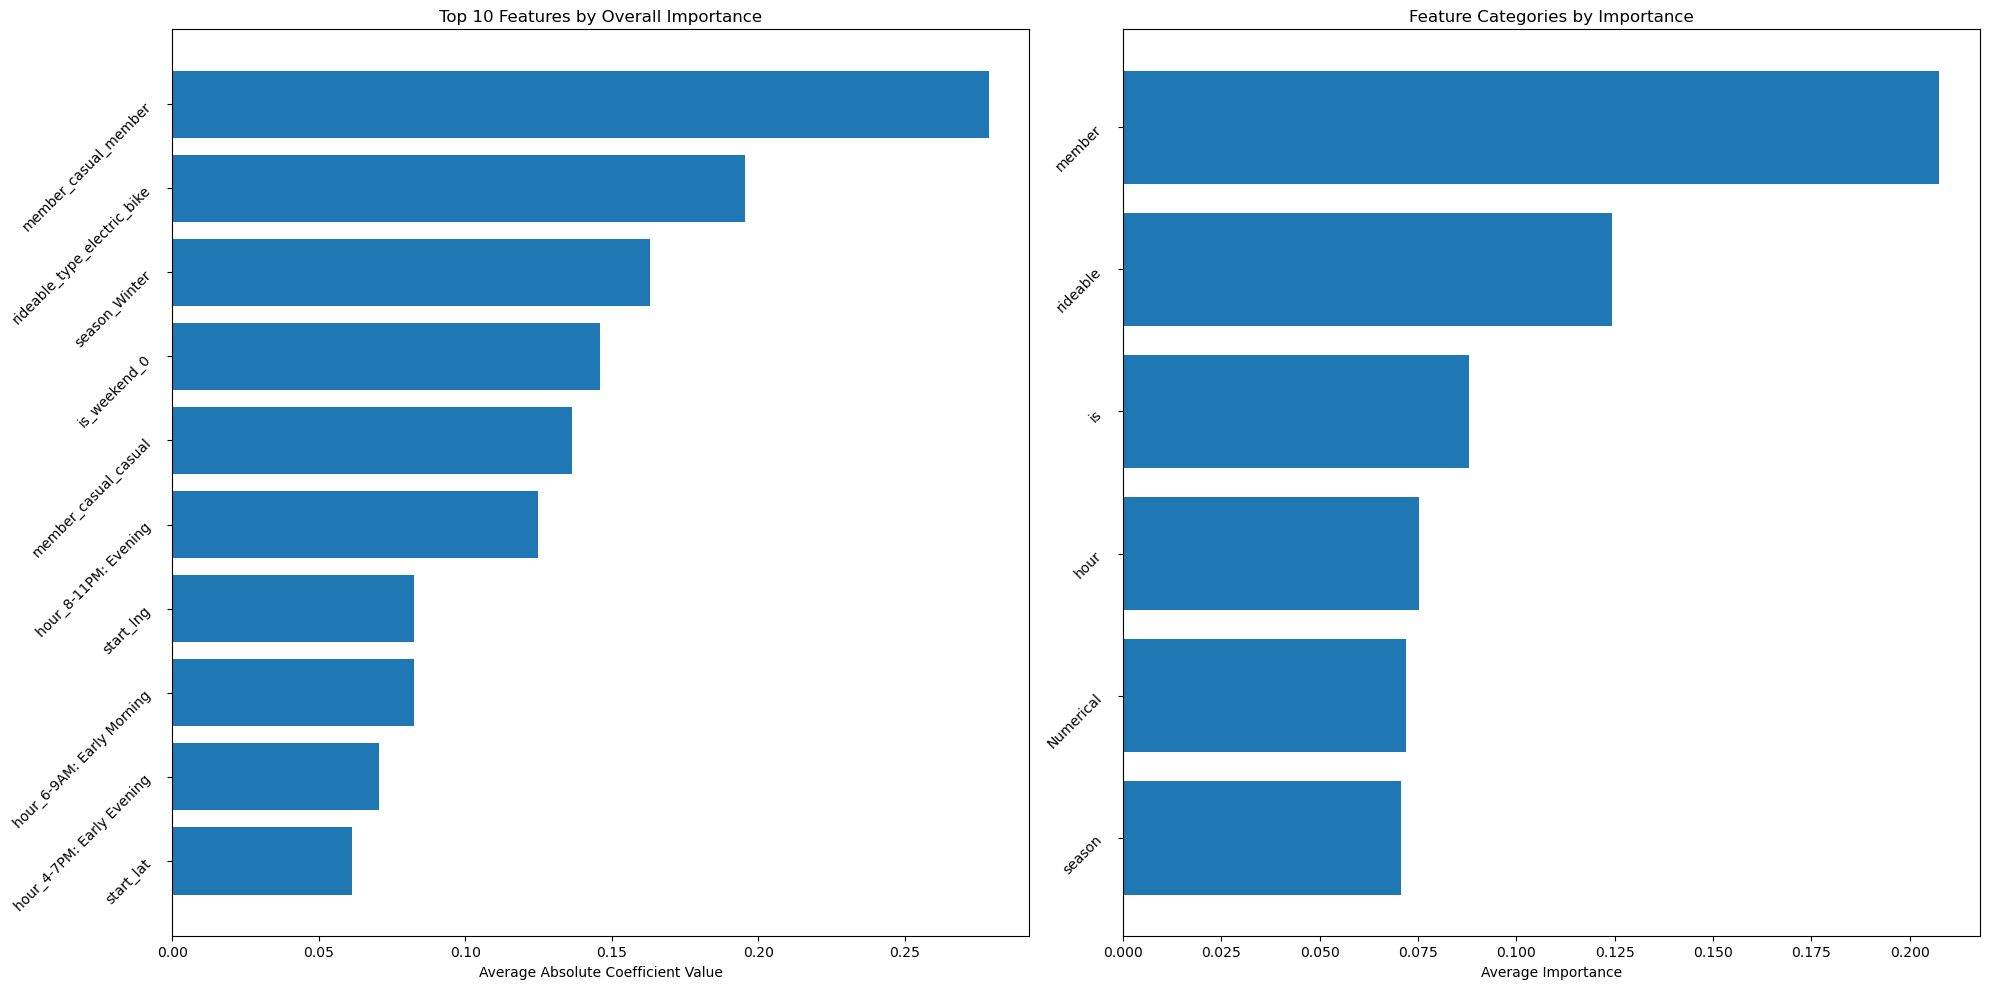

In [13]:
# Sid by side plots
fig, axes = plt.subplots(1, 3, figsize=(24, 10))

for idx, (class_name, importance_df) in enumerate(importance_dfs):
    top_features = importance_df.head(10)

    colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]

    axes[idx].barh(top_features['Feature'], top_features['Abs_Coefficient'], color=colors)

    for j, (feature, coef, abs_coef) in enumerate(zip(
        top_features['Feature'], 
        top_features['Coefficient'], 
        top_features['Abs_Coefficient']
    )):
        
        axes[idx].text(abs_coef + 0.01, j, f"{coef:.4f}", va='center', fontsize=9)
    
    axes[idx].set_xlabel('Absolute Coefficient Value')
    axes[idx].set_title(f'"{class_name}" class')
    axes[idx].invert_yaxis()  
  
    axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=45, ha='right')
    axes[idx].tick_params(axis='y', which='major', pad=10)

    if idx == 0:
        import matplotlib.patches as mpatches
        red_patch = mpatches.Patch(color='red', label='Negative Coefficient')
        green_patch = mpatches.Patch(color='green', label='Positive Coefficient')
        axes[idx].legend(handles=[green_patch, red_patch], loc='lower right')

    axes[idx].set_xlim(0, max(top_features['Abs_Coefficient']) * 1.15)

fig.suptitle('Top 10 Features by Importance for Each Rider Class', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

# Create another figure for the overall importance and category importance side by side
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Overall feature importance
ax1.barh(overall_importance_df['Feature'][:10], overall_importance_df['Average_Importance'][:10])
ax1.set_xlabel('Average Absolute Coefficient Value')
ax1.set_title('Top 10 Features by Overall Importance')
ax1.invert_yaxis()
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=45, ha='right')
ax1.tick_params(axis='y', which='major', pad=10)

# Plot 2: Category importance
ax2.barh(category_df['Category'], category_df['Average_Importance'])
ax2.set_xlabel('Average Importance')
ax2.set_title('Feature Categories by Importance')
ax2.invert_yaxis()
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=45, ha='right')
ax2.tick_params(axis='y', which='major', pad=10)

plt.tight_layout()
plt.show()